# 02-Data Preparation

_[Estimated execution time: 3 min]_

This notebook shows how to manipulate data before training, including:

* Filter data by ranges
* Aggregate data
* Randomly remove observations
* Apply data transformations

In [20]:
import mogptk
import numpy as np

### Data load

First we load the gold, oil, NASDAQ and USD dataset which contains daily index prices of gold, oil, NASDAQ USD from 1980 to 2019.

We create a [`mogptk.DataSet`](https://games-uchile.github.io/mogptk/dataset.html) containing a [`mogptk.Data`](https://games-uchile.github.io/mogptk/data.html) for each channel with the X and Y data.

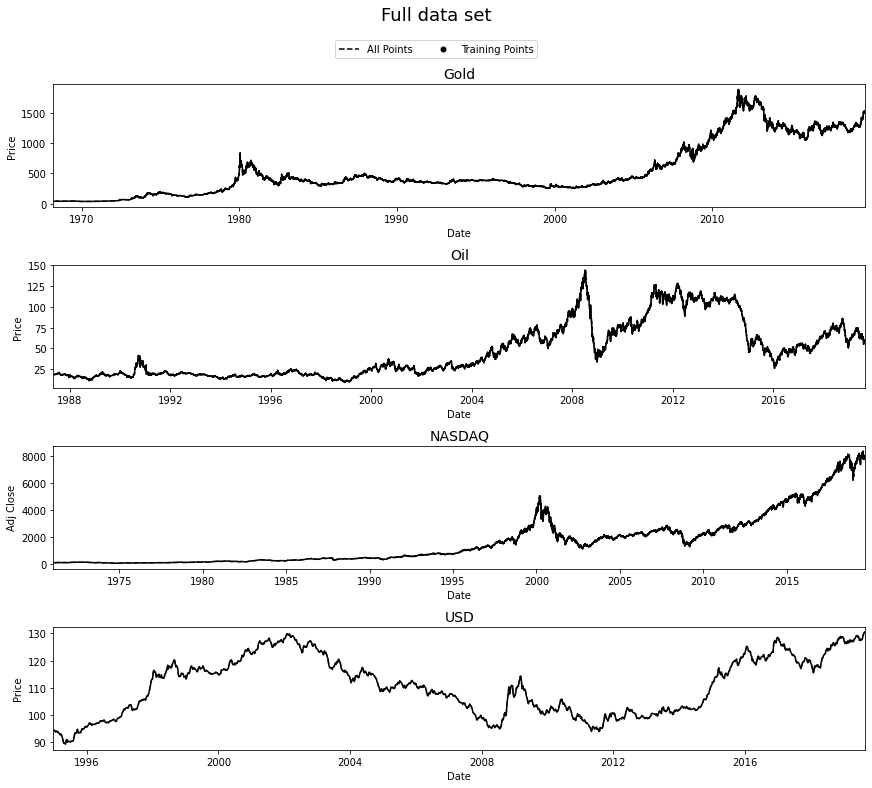

In [2]:
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      x_col='Date', y_col='Price', name='Gold',
                      na_values='.')

oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     x_col='Date', y_col='Price', name='Oil')

nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        x_col='Date', y_col='Adj Close',
                        name='NASDAQ')

usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     x_col='Date', y_col='Price', name='USD')

dataset = mogptk.DataSet(gold, oil, nasdaq, usd)
dataset.plot('Full data set');

## Data filtering

We now filter for each channel between 2015 and 2018 using [`mogptk.Data.filter`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.filter).

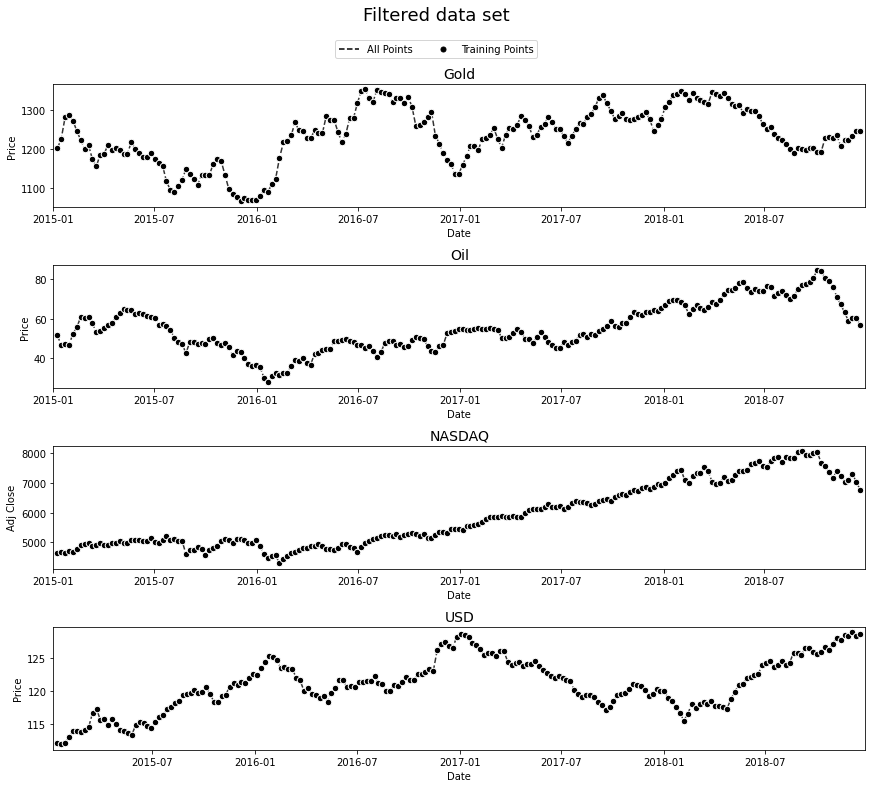

In [7]:
for channel in dataset:
    channel.filter('2015-01-01', '2018-12-31')

dataset.plot('Filtered data set');

## Data aggregation

In order to reduce the number of points we will agregate the data per week by taking the mean value for each 7 days using [`mogptk.Data.aggregate`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.aggregate).

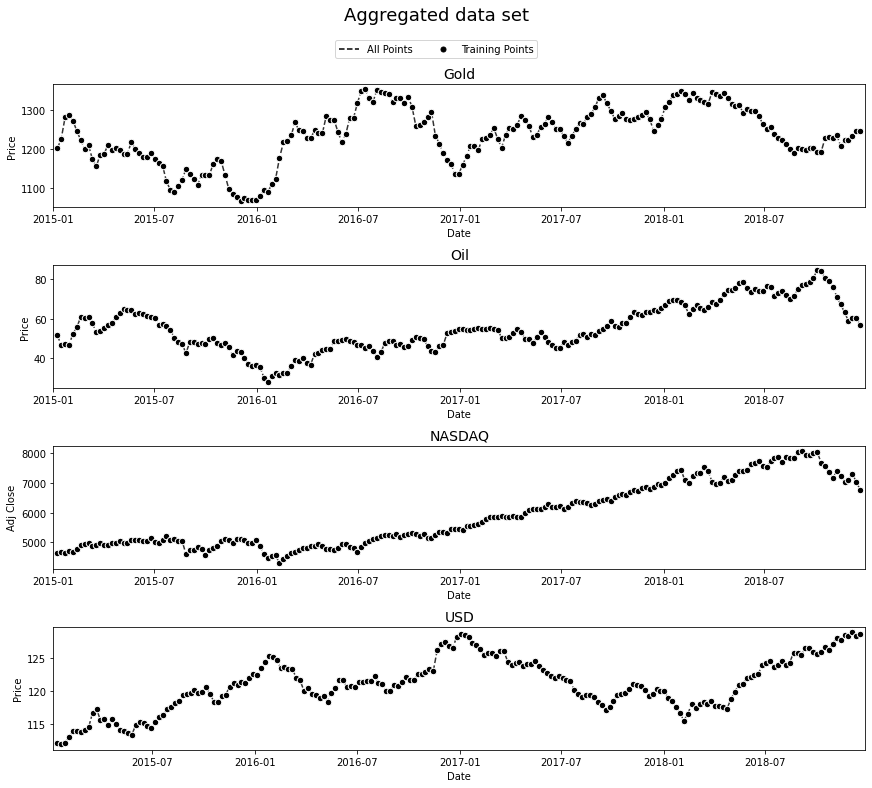

In [6]:
for channel in dataset:
    channel.aggregate('7D')

dataset.plot('Aggregated data set');

## Data removal

In order to simulate missing values of temporary failures in sensors, for each channel we will remove data points randomly with [`mogptk.Data.remove_randomly`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_randomly). Removing a range in an input dimension can be performed using [`mogptk.Data.remove_range`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_range).

In practice this points are not erased, but instead a boolean-mask is created at `mogptk.Data.mask`. At this point, the [`mogptk.DataSet.plot`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.plot) will treat the remaining points as training points.

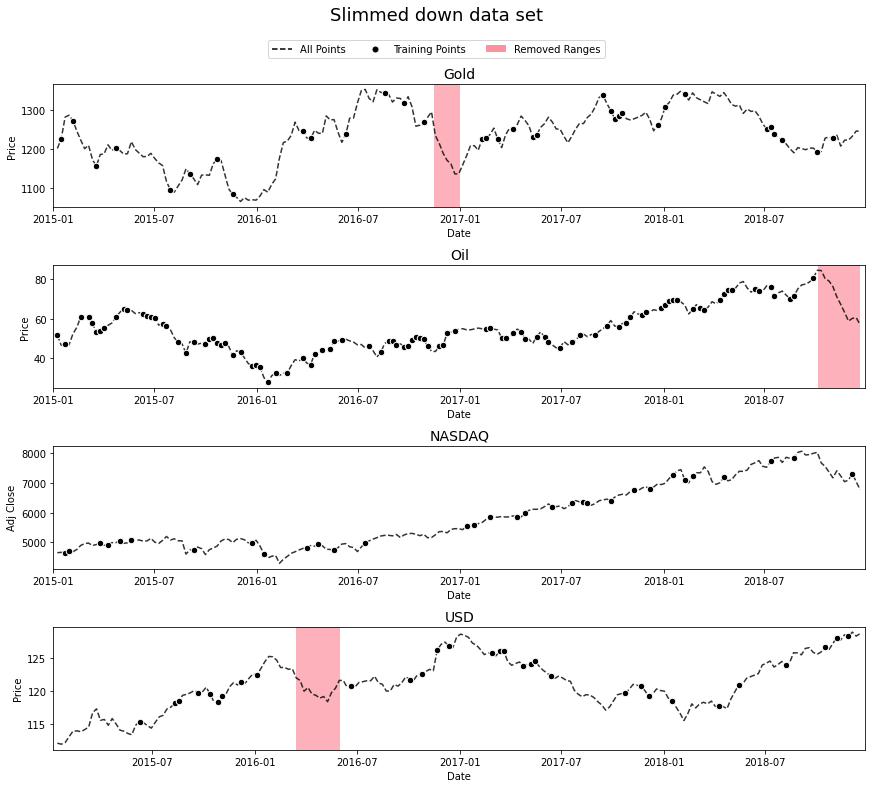

In [10]:
for i, channel in enumerate(dataset):        
    if i == 0:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 1:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
dataset.plot('Slimmed down data set');

## Transformations

We can clearly see there is a trend in the data which prevents Gaussian processes from training effectively. By transforming the data before training we can dramatically improve training results. In this case we will detrend the data using a first-order polynomial regression.

Transformations available are:
* [`mogptk.TransformDetrend`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformDetrend): detrend by fitting a polynomial of given degree
* [`mogptk.TransformNormalize`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformNormalize): normalize so the data is in the range [-1, 1]
* [`mogptk.TransformLog`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformLog): take the log of the data
* [`mogptk.TransformWhiten`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformWhiten): whiten the data so that it has zero mean and unit variance
* [`mogptk.TransformLinear`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformLinear): linearly transform the data given `a` and `b` so that `y => a*y + b`

**_New transformations_** classes can be implemented by defining 3 methods.

* `set_data()`: sets the data in order to obtain parameters of the transformations (e.g the mean of a normalization or coefficients of a linear regression)
* `forward()`: apply the transformation
* `backward()`: apply the inverse transformation

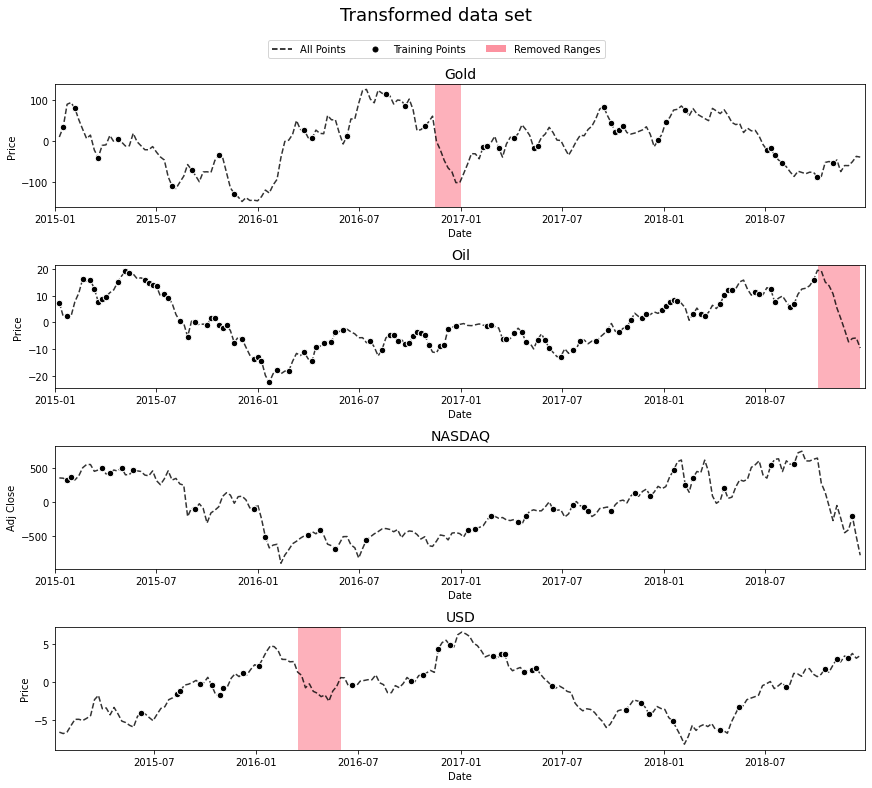

In [14]:
dataset.transform(mogptk.TransformDetrend(degree=1))   
dataset.plot('Transformed data set', transformed=True);

We can use a new type of transformation for our data by creating a transformation class. This class contains the `set_data()` method taking as argument an `mogptk.Data` object, and has `forward` and `backward` methods. We can access the function values with the attribute `mogptk.Data.Y.transformed`. 

In [15]:
class TransformWhiten(mogptk.TransformBase):
    """
    Transform the data so it has mean 0 and variance 1
    """
    def __init__(self):
        pass
    
    def set_data(self, data):
        self.mean = data.Y.transformed[data.mask].mean()
        self.std = data.Y.transformed[data.mask].std()
        
    def forward(self, y, x=None):
        return (y - self.mean) / self.std
    
    def backward(self, y, x=None):
        return (y * self.std) + self.mean

Now we apply the transformation and also a log transformation

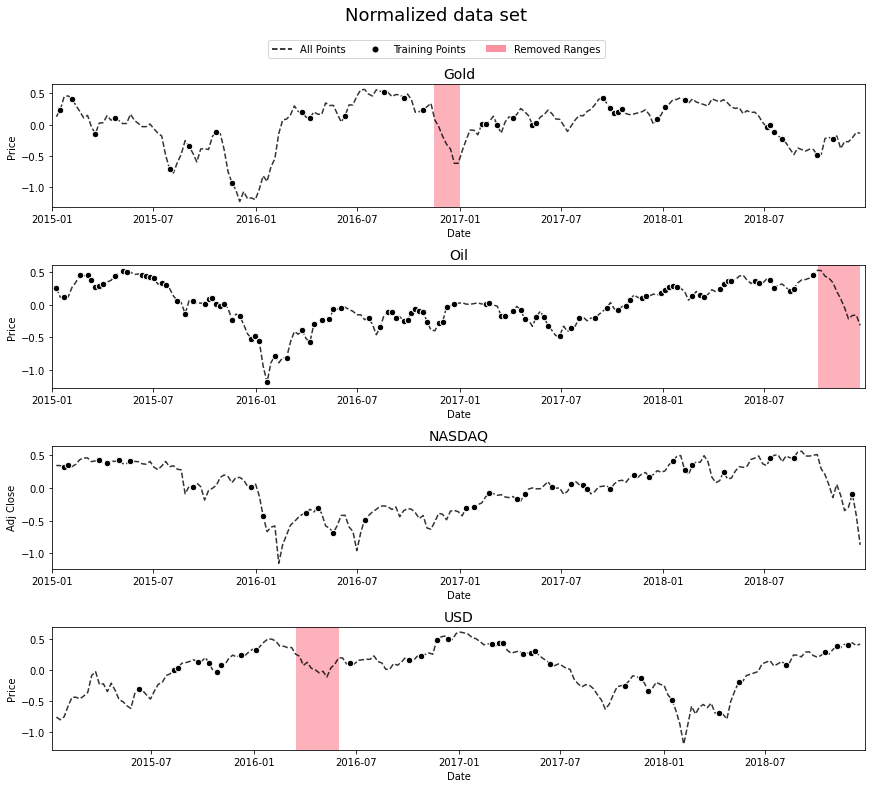

In [16]:
for channel in dataset:
    channel.transform(TransformWhiten())
    channel.transform(mogptk.TransformLog())
    
dataset.plot('Normalized data set', transformed=True);

## Training

With the final dataset we can train the model using the transformed dataset, but the predictions will be shown in the original space.


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 193
‣ Parameters: 72
‣ Initial NLL: 1.593

Optimization finished in 0.40 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.082


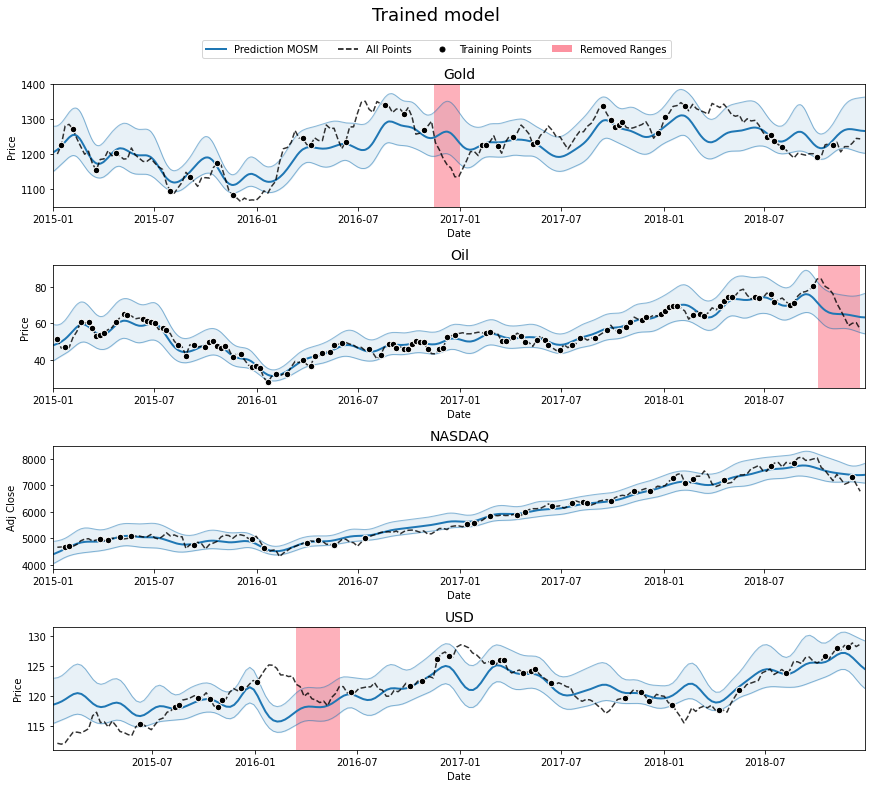

In [19]:
# create model
model = mogptk.MOSM(dataset, Q=3)

# initial estimation of parameters
model.init_parameters()

# train
model.train(iters=500, verbose=True)

# predict and plot
model.predict()
dataset.plot(title='Trained model');